In [1]:
import os
import random
import re
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [2]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [3]:
rnaseq_df.head(5)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
0,0.678296,0.289910,0.034230,0.0,0.000000,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
1,0.200633,0.654917,0.181993,0.0,0.000000,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560
2,0.785980,0.140842,0.081082,0.0,0.000000,0.000000,0.000000,0.000000,0.730648,0.657189,...,0.437658,0.471489,0.868774,0.471141,0.487212,0.385521,0.466642,0.784059,0.160797,0.557074
3,0.720258,0.122554,0.180042,0.0,0.000000,0.000000,0.000000,0.000000,0.720306,0.719855,...,0.553306,0.373344,0.818608,0.691962,0.635023,0.430647,0.453690,0.364494,0.161363,0.607895
4,0.767127,0.210393,0.034017,0.0,0.061161,0.000000,0.053021,0.000000,0.739546,0.665684,...,0.601268,0.379943,0.506839,0.684320,0.607821,0.320113,0.476190,0.122722,0.389544,0.698548


In [4]:
import pandas as pd
import umap.umap_ as umap

# Perform UMAP dimensionality reduction
umap_result = umap.UMAP().fit_transform(rnaseq_df)

# Create a new DataFrame with UMAP coordinates
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df = pd.concat([rnaseq_df, umap_df], axis=1)

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/umap/distances.py:108

In [5]:
embedded_dataframe = result_df.copy()

In [6]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
df = pd.read_table(tcga_tybalt_file_location)
# df.drop(columns=df.columns[0], axis=1, inplace=True)

In [7]:
embedded_dataframe["id"] = df["Unnamed: 0"]

In [8]:
# clinical data
clincal_file = "../../VAE_prject_data/raw/clinical_data.tsv"
clincal_df = pd.read_table(clincal_file)

In [9]:
clincal_df["id"] = clincal_df.portion_id.str[: embedded_dataframe["id"].str.len().min()]

In [10]:
merged_latent_clinical_df = pd.merge(
    clincal_df, embedded_dataframe, on="id", how="inner"
)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

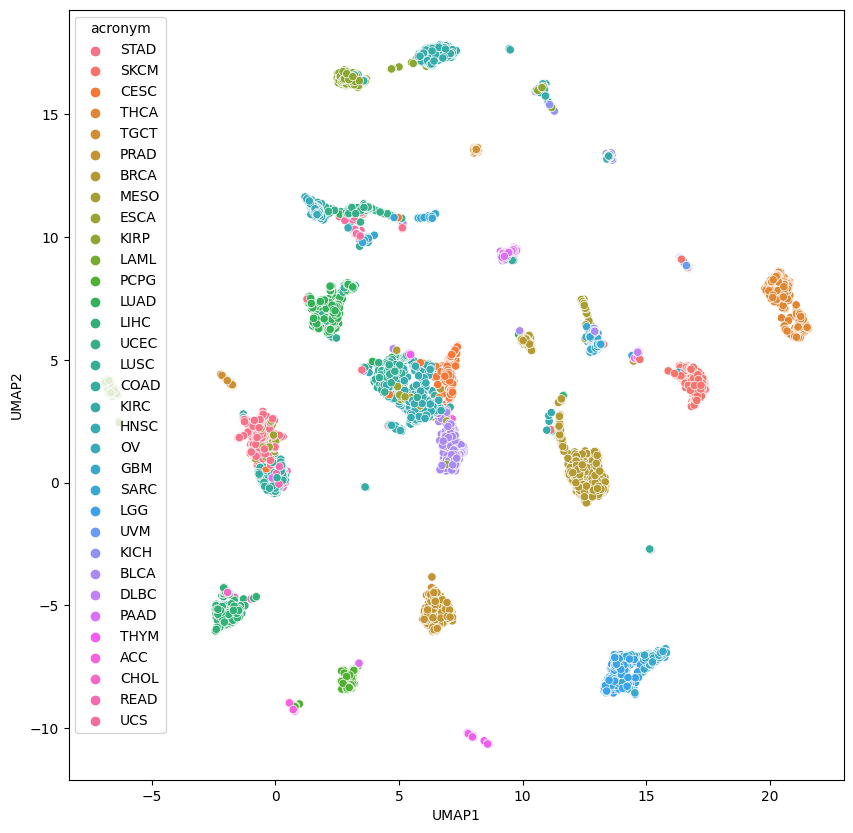

In [11]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="acronym")